In [7]:
import sys
sys.path.insert(0,'C:\\code\\python_for_the_financial_economist\\')

"""
Magic commands
"""

%load_ext autoreload
%autoreload 2

# animations, etc. requires below magic command
# %matplotlib notebook


"""
Load relevant packages
"""

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib import animation, cm

from scipy import stats
from scipy import optimize
from scipy.optimize import minimize

import seaborn as sns

#import autograd
# functions to approx derivative and hessian 
from statsmodels.tools.numdiff import approx_fprime, approx_hess

"""
Own packages
"""

from codelib.statistics.moments import calculate_cov_mat,  calculate_cov_mat_factor, calculate_outer_product

import codelib.statistics.historical_probabilities as hp

from codelib.portfolio_optimization.risk_budget import calculate_risk_contributions_std

from codelib.visualization.layout import DefaultStyle
DefaultStyle();

from codelib.visualization.base import waterfall_chart

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Introduction to estimation 

Estimation is key in financial economics!  The distribution of market invariants (e.g. returns) will generally be unknown and even if we can assume a particular distribution we need to be able to estimate the parameters describing the particular distribution. 

The choice of estimator will depend on a range of factors. Generally, the [variance-bias tradeoff](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff) tells us that we with large amounts of data can apply very flexible non-parametric estimators while we may need to impose distributional assumptions or even shrinkage with less data. 

## What is an estimator? 

An [estimator](https://en.wikipedia.org/wiki/Estimator), typically denoted $\hat{\theta} (\mathbf{X})$, maps a random sample $X_1, ..., X_n$ (stacked in the vector $\mathbf{X}$) defined by e.g. the pdf $f_X(x;\theta)$, where $\theta$ is an unknown parameter, to a set of _sample estimates_. It is important to note that the estimator is a function of random variables and therefore itself a random variable. 

For a particular realization of the random sample $x_1, ..., x_n$ (stacked in the vector $\mathbf{x}$), we obtain the estimate $\hat{\theta} (\mathbf{x})$ which is a fixed value. 

Some well-known estimators include the _sample mean_

$$
\begin{equation*}
\bar{X} = \frac{1}{n} \sum_{i=1}^n X_i
\end{equation*}
$$

The _sample variance_
$$
\begin{equation*}
S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2
\end{equation*}
$$

The _sample covariance_

$$
\begin{equation*}
C_{X,Y} = \frac{1}{n} \sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})
\end{equation*}
$$




## Properties of estimators 

We will discuss some important properties of estimators

* Unbiasedness
* Consistency
* Efficiency
* Asymptotic normality

### Unbiasedness

An estimator will take on different values from sample to sample (the estimate), but we would like the property that we on average get the right estimate. 

An estimator is said to be [unbiased](https://en.wikipedia.org/wiki/Bias_of_an_estimator) if its expected value is equal to the true value $\theta$: 

$$
\text{E}[\hat{\theta} (\mathbf{X})]  = \theta
$$

__Example: Sample mean__

Let $X_1,...,X_n$ be an independent sample of size $n$ all with the same pdf and mean $\text{E}[X_i] = \mu$. Define the sample mean

$$
\begin{equation*}
\bar{X}_n = \frac{1}{n} \sum_{i=1}^n X_i
\end{equation*} 
$$

Then due to independence, 

$$
\begin{align*}
E[\bar{X}_n] &=  \frac{1}{n} \sum_{i=1}^n \text{E}[X_i] = \mu  \\
\text{Var}[\bar{X}_n] &= \frac{1}{n^2} \sum_{i=1}^n \text{Var}[X_i] = \frac{\sigma^2}{n}
\end{align*}
$$

Thus, the sample mean is an unbiased estimator. 

__Example: A single realization__

Choosing the value of a single realization will also be an unbiased estimator since $\text{E}[X_i] = \mu$. The problem is of course that the variance of this estimator is $\text{Var}[X_i] = \sigma^2 > \frac{\sigma^2}{n}$. 

__Example: Sample variance__

An natural estimator for the variance is given by

$$
\begin{equation*}
\hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (X_i - \bar{X})^2
\end{equation*}
$$

However, one can show that 
$$
\begin{equation*}
\text{E}[\hat{\sigma}^2] = \frac{n-1}{n} \sigma^2
\end{equation*}
$$

Hence, it is not an unbiased estimator and we therefore typically use 

$$
\begin{equation*}
S^2 = \frac{1}{n-1} \sum_{i=1}^n (X_i - \bar{X})^2
\end{equation*}
$$


### Consistency

An estimator $\hat{\theta}(\mathbf{X})$ is said to be [consistent](https://en.wikipedia.org/wiki/Consistent_estimator) for $\theta$ if it converges in probability to $\theta$ - that is, if for all $\varepsilon>0$, 

$$
\begin{equation*}
\lim_{n\to\infty} P(\vert \hat{\theta}(\mathbf{X}) - \theta\vert < \varepsilon) = 1
\end{equation*}
$$

which we also will write as 

$$
\text{plim } \hat{\theta}(\mathbf{X}) = \theta
$$

For consistency, it is sufficient to show that (almost sure convergence)

$$
\begin{equation*}
\lim_{n\to \infty} \text{E}[\hat{\theta}(\mathbf{X})] = \theta
\end{equation*}
$$

and

$$
\begin{equation*}
\lim_{n\to \infty}\text{Var}[\hat{\theta}(\mathbf{X})] = 0
\end{equation*}
$$

__Example: The sample mean__

Again, let $X_1,...,X_n$ be an independent sample of size $n$ all with the same pdf and mean $\text{E}[X_i] = \mu$. 

The [Law of Large Numbers (LLN)](https://en.wikipedia.org/wiki/Law_of_large_numbers)  tells us (under some regularity conditions) that 

$$
\begin{equation*}
\text{plim } \bar{X}_n = \mu
\end{equation*}
$$
or more precisely 

$$
\begin{equation*}
\lim_{n \to \infty} P(\vert \bar{X}_n - \mu \vert > \varepsilon) = 0
\end{equation*}
$$

for all $\varepsilon>0$. We call this for convergence in probability. 

We note that 

$$
\begin{align*}
\text{E}[\bar{X}_n] &=  \frac{1}{n} \sum_{i=1}^n \text{E}[X_i] = \mu  \\
\text{Var}[\bar{X}_n] &= \frac{1}{n^2} \sum_{i=1}^n \text{Var}[X_i] = \frac{\sigma^2}{n}
\end{align*}
$$

implying that the sample mean is unbiased and the variance converges to zero with the sample size. Thus, we have almost sure convergence. 

As an example, we consider the uniform distribution $X \sim U(-5,5)$. Draw 10, 100, 500 and 1000 observations from the uniform distribution 10,000 times, calculate the sample mean for each iteration and blot the histogram of the sample means.

We see that the distribution collapses around the true value!

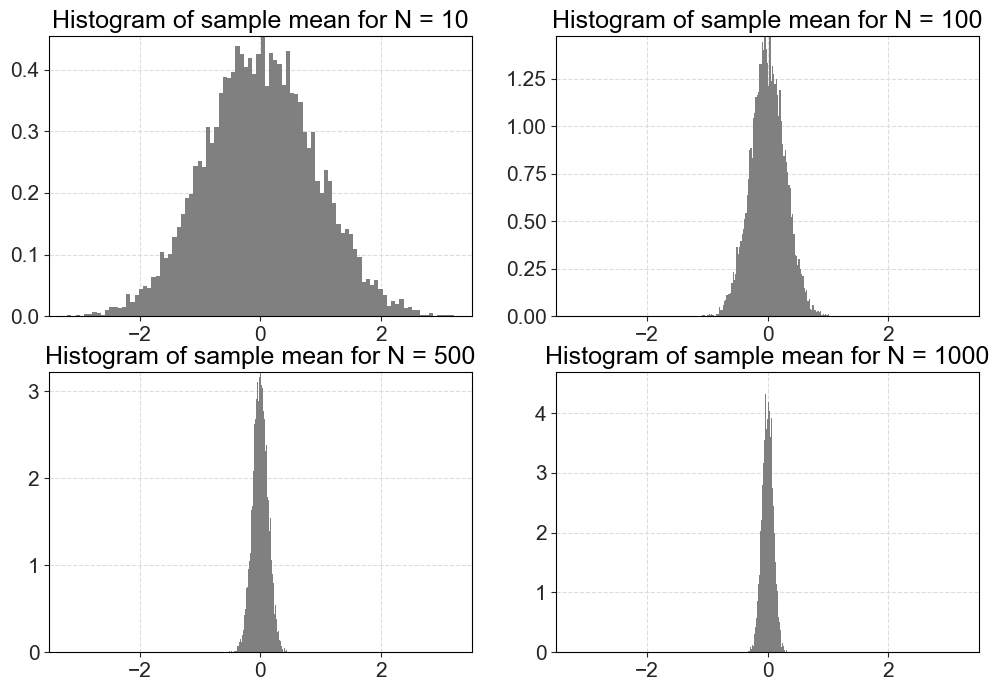

In [8]:
"""
Draw uniform numbers
"""
a = -5.0
b = 5.0

uniform_data = np.random.uniform(low=a, high=b, size=(1000, 10000))

true_var = (b-a)**2/12
true_mean = (a + b)/2

fig, ax_ = plt.subplots(2,2, figsize=(12,8))

ax_ = ax_.flatten()


for i, N in enumerate([10, 100, 500, 1000]): 

    ax = ax_[i]
    
    # get section of generated data
    data = uniform_data[:N, :]
    
    # calculate sample means
    sample_means = np.mean(data, axis=0)
    
    # plot histogram 
    ax.hist(sample_means, color="gray", bins=100, zorder=1, density=True)
    
    ax.set_title("Histogram of sample mean for N = " + str(N))
    ax.set_axisbelow(True)
    ax.set_xlim([-3.5,3.5]);

### Efficiency 

If we have two unbiased estimators for a parameter $\theta$, $\hat{\theta}_1$ and $\hat{\theta}_2$, then if 

$$
\begin{equation*}
\text{Var}[\hat{\theta}_1] < \text{Var}[\hat{\theta}_2]
\end{equation*}
$$
we say that $\hat{\theta}_1$ is more efficient than $\hat{\theta}_2$.


A classical example (already mentioned) is that an element in a sample $X_i$ is an unbiased estimator of the expected value, just as the sample mean

$$
\begin{equation*}
\text{E}[X_i] = \mu
\end{equation*}
$$

However, this estimator has the variance $\sigma^2$ while the variance of the sample mean is 

$$
\begin{equation*}
\text{Var}[\bar{X}] = \frac{1}{n^2}\sum_{i=1}^n \text{Var}[X_i] = \frac{\sigma^2}{n}
\end{equation*}
$$

Clearly more efficient!

__Cramér-Rao's lower bound__

It will generally hold that if we have a random sample $X_1,...,X_n$ from the pdf $f_X(x;\theta)$, where $\theta$ is an unknown parameter and the estimator $\hat{\theta}(\mathbf{X})$, then 

$$
\begin{equation*}
\text{Var}[\hat{\theta}] \geq \left[n \text{E} \left[ \left(\frac{\partial \ln f_X(X; \theta)}{\partial \theta} \right)^2\right] \right]^{-1} = \left[ -n \text{E} \left[ \frac{\partial^2 \ln f_X(X; \theta)}{\partial \theta^2}\right]\right]^{-1}
\end{equation*}
$$

which is known as [Cramér-Rao's lower bound](https://en.wikipedia.org/wiki/Cram%C3%A9r%E2%80%93Rao_bound). We will later see that the maximum-likelihood estimator satisfies Cramér-Rao's lower bound ensuring that the maximum-likelihood estimator is the most efficient. 

__Example: Sample mean__

Let $X_1,...,X_n$ be an independent sample of size $n$ all with $X_i \sim N(\mu, \sigma^2)$. Then, we have

$$
\frac{\partial \ln f_X(X; \mu, \sigma)}{\partial \mu} = \frac{\partial }{\partial \mu} \left[- \ln (\sigma \sqrt{2\pi}) -\frac{(X-\mu)^2}{2 \sigma^2} \right] = -2 \frac{X-\mu}{2 \sigma^2} = -\frac{X-\mu}{ \sigma^2} 
$$

and 

$$
\text{E}\left[ \left(-\frac{X-\mu}{ \sigma^2} \right)^2 \right] = \text{E}\left[ \frac{1}{\sigma^2} \frac{(X-\mu)^2}{ \sigma^2} \right] =  \frac{1}{\sigma^2}  \frac{ \text{E}\left[(X-\mu)^2 \right]}{ \sigma^2} = \frac{1}{\sigma^2}  \frac{ \sigma^2}{ \sigma^2} = \frac{1}{\sigma^2} 
$$

Thus, the lower-bound for the variance is 

$$
\text{Var}[\hat{\mu}] \geq \left[n  \frac{1}{\sigma^2} \right]^{-1} = \frac{\sigma^2}{n}
$$

showing that the sample mean is the most efficient estimator (unbiased) in the normal case. 


### Asymptotic normality 

A consistent estimator is said to be asymptotically normally distributed if the distribution of the estimator converges to a normal distribution, typically, at the rate $1 / \sqrt{n}$ (the standard deviation shrinks at this rate). We will write 

$$
\sqrt{n} (\hat{\theta} - \theta) \to^d N(0, V)
$$

where $V/n$ is called the asymptotic variance. 

__Example: Sample mean__

[The Central Limit Theorem (CLT)](https://en.wikipedia.org/wiki/Central_limit_theorem) tells us that for an iid random sample of size $n$ and if $\sigma < \infty$

$$
\begin{equation*}
\lim_{n\to \infty} P\left(\frac{\bar{X}_n - \mu}{\sigma/\sqrt{n}} < z \right) = \Phi(z)
\end{equation*}
$$
where $\Phi(z)$ denotes the standard normal cdf. 

It follows directly that 

$$
\sqrt{n}(\bar{X}_n - \mu) \to^d N\left(0, \frac{\sigma^2}{n}\right)
$$

## A brief look at Ordinary Least Squares (OLS)

We will write a linear regression model (using matrix notation) as 

$$
\mathbf{y} = \mathbf{X}\boldsymbol{\beta} + \mathbf{e}
$$

where $\mathbf{y}$ is the $n \times 1$ vector of dependent variables, $\mathbf{X}$ is the $n \times k$ matrix of regressors (independent variables) and $\mathbf{e}$ is the $n \times 1$ error vector. 

As the name implies, the OLS estimator minimizes the sum of squared residuals 

$$
Q_n (\boldsymbol{\beta}) = \sum_{i=1}^n (y_i - \mathbf{x}_i^\top \boldsymbol{\beta} )^2 = (\mathbf{y} - \mathbf{X}\boldsymbol{\beta})^\top (\mathbf{y} - \mathbf{X}\boldsymbol{\beta}) = \mathbf{e}^\top \mathbf{e}
$$

Taking the derivative wrt. $\boldsymbol{\beta}$ and setting equal to zero yields the estimator 

$$
\hat{\boldsymbol{\beta}}_{OLS} = (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y}
$$


### Properties of OLS

__Note__: It is not expected that you know all the finer details in deriving the asymptotic properties of e.g. the OLS estimator, but only how to implement derived formulas in Python. 

__Consistency__

$$
\begin{align}
\hat{\boldsymbol{\beta}}_{OLS} &= (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{y} \\
&= (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top (\mathbf{X}\boldsymbol{\beta} + \mathbf{e}) \\
&= (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{X}\boldsymbol{\beta} + (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{e} \\
&= \boldsymbol{\beta} + (\mathbf{X}^\top \mathbf{X})^{-1} \mathbf{X}^\top \mathbf{e} \\
&= \boldsymbol{\beta} + \left(\frac{1}{n}\mathbf{X}^\top \mathbf{X}\right)^{-1} \frac{1}{n}\mathbf{X}^\top \mathbf{e} 
\end{align}
$$

Basically, for consistency we need (without going into details)

$$
\text{plim} \frac{1}{n}\mathbf{X}^\top \mathbf{X} = \lim \frac{1}{n} \text{E} \left[ \mathbf{X}^\top\mathbf{X} \right]  =  \mathbf{M_{xx}}
$$

where $\mathbf{M_{xx}}$ is a non-singular matrix (invertible), and 

$$
\text{plim} \frac{1}{n}\mathbf{X}^\top \mathbf{e} =  \lim \frac{1}{n} \text{E} \left[ \mathbf{X}^\top\mathbf{e} \right] =\mathbf{0}
$$

requiring the regressors and error term to be uncorrelated. 

__Asymptotic normality__

Rewritting the above expression yields 

$$
\sqrt{n}(\hat{\boldsymbol{\beta}}_{OLS} - \boldsymbol{\beta}) = \left(\frac{1}{n}\mathbf{X}^\top \mathbf{X}\right)^{-1} \frac{1}{\sqrt{n}}\mathbf{X}^\top \mathbf{e} 
$$

If we can apply a CLT to $\frac{1}{\sqrt{n}}\mathbf{X}^\top \mathbf{e}$ such that it converges to multivariate normal distribution with finite, non-singular covariance matrix, we will have asymptotic normality. 

Assuming that 

$$
\frac{1}{\sqrt{n}}\mathbf{X}^\top \mathbf{e} \to^d N(\mathbf{0}, \mathbf{M_{x\Omega x}})
$$

with  (here $\boldsymbol{\Omega}=\text{E}[\mathbf{e} \mathbf{e}^\top \vert \mathbf{X}] = \text{Diag}[\sigma_i^2]$ is the covariance matrix of the errors)

$$
\text{plim} \frac{1}{n}\mathbf{X}^\top \mathbf{e} \mathbf{e}^\top\mathbf{X} = \text{plim} \frac{1}{n}\mathbf{X}^\top  \boldsymbol{\Omega} \mathbf{X}  = \mathbf{M_{x\Omega x}}
$$

then it will be possible to show that 

$$
\sqrt{n}(\hat{\boldsymbol{\beta}}_{OLS} - \boldsymbol{\beta}) \to^d N\left(\mathbf{0}, \mathbf{M_{xx}}^{-1} \mathbf{M_{x\Omega x}}\mathbf{M_{xx}}^{-1}\right)
$$

__Homoskedasticity vs. heteroskedasticity__

If $\boldsymbol{\Omega}=\text{E}[\mathbf{e}^\top \mathbf{e} \vert \mathbf{X}] = \text{Diag}[\sigma^2] = \sigma^2 \mathbf{I}$ then the error term is said to be homoskedastic and 

$$
\sqrt{n}(\hat{\boldsymbol{\beta}}_{OLS} - \boldsymbol{\beta}) \to^d N\left(\mathbf{0}, \sigma^2 \mathbf{M_{xx}}^{-1} \mathbf{M_{xx}}\mathbf{M_{xx}}^{-1}\right) = N\left(\mathbf{0}, \sigma^2 \mathbf{M_{xx}}^{-1} \right) 
$$

where we will estimate $\hat{\mathbf{M}}_{\mathbf{xx}} = \frac{1}{n} \mathbf{X}^\top\mathbf{X}$ and $\sigma^2$ using the sample variance. 

$$
S^2 = \frac{1}{n - k} \hat{\mathbf{e}}^\top \hat{\mathbf{e}}
$$

This leads to the variance estimator of the OLS estimator

$$
\hat{\text{Var}}[\hat{\boldsymbol{\beta}}_{OLS}] = S^2 \left( \mathbf{X}^\top\mathbf{X} \right)^{-1}
$$

If the error term is heteroskedastic then $\sigma_i^2$ differs between observations. [Heteroscedastic robust standard errors](https://en.wikipedia.org/wiki/Heteroscedasticity-consistent_standard_errors) can be obtained using (under some regularity conditions)

$$
\hat{\text{Var}}[\hat{\boldsymbol{\beta}}_{OLS}] = \left( \mathbf{X}^\top\mathbf{X} \right)^{-1} \mathbf{X}^\top \hat{\boldsymbol{\Omega}}\mathbf{X} \left( \mathbf{X}^\top\mathbf{X} \right)^{-1}
$$

where $\hat{\boldsymbol{\Omega}} = \text{Diag}[\hat{e}_i^2]$. 

__Example: Distribution of  OLS estimator__

Consider the regression model

$$
y_i = \alpha + \beta_1 x_{1, i} + \beta_{2, i} x_{2, i} + \varepsilon_i =  \mathbf{x}_i^\top \boldsymbol{\beta} + \varepsilon_i
$$

where $\alpha=1$, $\beta_1 = 1$, and $\beta_2 = 1$. Furthermore, assume that $x_{1, i} \sim \log N(0, 1)$, $x_{2, i} \sim \log N(0, 1)$ and $\varepsilon_{i} + e^{\frac{0.1^2}{2}} \sim \log N(0, 0.1^2)$ (we added the mean to make the error term have a mean of zero). 

Simulate and estimate the model with OLS 10,000 times for different sample sizes. Plot the kernel density of the estimates. What do you observe, when the sample size increases?

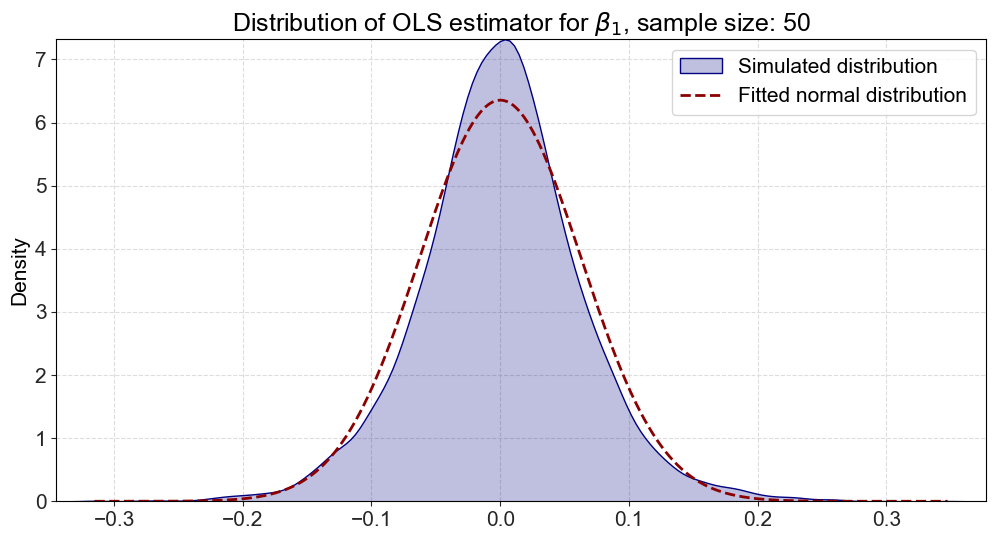

In [9]:
"""
Settings
"""

# number of simulations
num_sim = 10000

# sample size 
sample_size = 50

# true parameter values: constant, beta1, beta2
beta0 = np.array([1.0, 1.0, 1.0])

"""
Simulations
"""

all_beta_est = np.empty((num_sim, len(beta0)))
for i in range(num_sim): 
    
    # generate independent variables
    x1_sim = stats.lognorm.rvs(1, scale=1, size=sample_size) 
    x2_sim = stats.lognorm.rvs(1, scale=1, size=sample_size)
    x_mat_sim = np.vstack([np.ones(sample_size), x1_sim, x2_sim]).T

    # simulate error term
    eps_sim = stats.lognorm.rvs(0.1, loc=-np.exp(0.1**2 / 0.5), scale=1, size=sample_size) # s: sigma, scale: exp(mu), loc: exp(mu + sigma^2 / 2)

    # simulate dependent variable
    y_sim = x_mat_sim @ beta0 + eps_sim
    
    # estimate parameters
    beta_est, res, _, _ = np.linalg.lstsq(x_mat_sim, y_sim, rcond=-1)
    
    all_beta_est[i, :] = beta_est

"""
Plotting
"""
    
idx = 1 # 0: constant, 1: beta1, 2: beta2
param_name_dict = {0: '$\\alpha$', 1: '$\\beta_1$', 2: '$\\beta_2$'}
diff = (all_beta_est[:, idx] - beta0[idx]) * np.sqrt(sample_size)

fig, ax = plt.subplots(figsize=(12, 6))
sns.kdeplot(diff, color="navy", ax=ax, fill=True, alpha=0.25, label="Simulated distribution")

norm_params = stats.norm.fit(diff)

vals_to_eval = np.linspace(min(diff), max(diff), 1000)
ax.plot(vals_to_eval, stats.norm(norm_params[0], norm_params[1]).pdf(vals_to_eval), color="darkred", linestyle="--",
        label="Fitted normal distribution")

ax.set(title="Distribution of OLS estimator for " + param_name_dict[idx] + ", sample size: {}".format(sample_size))

ax.legend();

__Example: OLS with flexible probabilities__

We have previously introduced the idea to assign different probabilities to observations. It will also be possible to obtain the ordinary least squares estimates with "flexible" probabilities. One possible way of estimating OLS with flexible probabilites is given by

$$
\hat{\boldsymbol{\beta}}_{OLS,FL} = \left( \sum_{t=1}^T p_t \mathbf{x}_t  \mathbf{x}_t^\top \right)^{-1} \left( \sum_{t=1}^T p_t \mathbf{x}_t y_t  \right)
$$

where $p_t$ is the probability related to observation $t$. Note that we use "$t$" instead of "$i$" since we typically will apply flexible probabilites in a time series context. 

Use the Fama-French three-factor model to estimate factor loadings for industry portfolios with equally weighted probabilities and the case where we only assign probabilites to observations with a negative market excess return. 

In addition, calculate the standard deviation risk contributions when using the Fama-French factors. 

__Note:__ If we can write e.g. the return $\boldsymbol{Y}$ as a linear function of a set of risk drives $\boldsymbol{Z}$

$$
\mathbf{y} =  \mathbf{z}^\top \boldsymbol{\beta}
$$

Then, we can use the Euler principle to allocate the marginal risk contribution to the different factors. We are assuming that a possible idiosyncratic error (residual in our regression model) is included in the factors. 

If the risk measure is homogenous of degree one, we could write 

$$
RC_i = \beta_i \frac{\partial \rho (\mathbf{z}^\top \boldsymbol{\beta})}{\partial \beta_i}
$$

where $\rho()$ is the risk measure.  

In [10]:
"""
Obtain Fama-French data
"""

from pandas_datareader.famafrench import FamaFrenchReader, get_available_datasets

In [11]:
ff_data = FamaFrenchReader('F-F_Research_Data_Factors', start="1990-01-01").read()
ff_data['DESCR']

C:\Users\johan\AppData\Local\Temp\ipykernel_6628\2661235214.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = FamaFrenchReader('F-F_Research_Data_Factors', start="1990-01-01").read()
C:\Users\johan\AppData\Local\Temp\ipykernel_6628\2661235214.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff_data = FamaFrenchReader('F-F_Research_Data_Factors', start="1990-01-01").read()


'F-F Research Data Factors\n-------------------------\n\nThis file was created using the 202507 CRSP database. The 1-month TBill rate data until 202405 are from Ibbotson Associates. Starting from 202406, the 1-month TBill rate is from ICE BofA US 1-Month Treasury Bill Index. Copyright 2025 Eugene F. Fama and Kenneth R. French\n\n  0 : (427 rows x 4 cols)\n  1 : Annual Factors: January-December (35 rows x 4 cols)'

In [12]:
ff_monthly_returns = ff_data[0] / 100.0
ff_monthly_returns.head()

,Mkt-RF,SMB,HML,RF
Date,,,,
1990-01,-0.0780,-0.0114,0.0083,0.0057
1990-02,0.0112,0.0097,0.0065,0.0057
1990-03,0.0183,0.0147,-0.0290,0.0064
1990-04,-0.0336,-0.0047,-0.0257,0.0069
1990-05,0.0843,-0.0256,-0.0389,0.0068


In [13]:
industry_data = FamaFrenchReader('17_Industry_Portfolios', start="1990-01-01").read()
industry_data['DESCR']

C:\Users\johan\AppData\Local\Temp\ipykernel_6628\3008707431.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_data = FamaFrenchReader('17_Industry_Portfolios', start="1990-01-01").read()
C:\Users\johan\AppData\Local\Temp\ipykernel_6628\3008707431.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_data = FamaFrenchReader('17_Industry_Portfolios', start="1990-01-01").read()
C:\Users\johan\AppData\Local\Temp\ipykernel_6628\3008707431.py:1: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  industry_data = FamaFrenchR

'17 Industry Portfolios\n----------------------\n\nThis file was created using the 202507 CRSP database. It contains value- and equal-weighted returns for 17 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2025 Eugene F. Fama and Kenneth R. French\n\n  0 : Average Value Weighted Returns -- Monthly (427 rows x 17 cols)\n  1 : Average Equal Weighted Returns -- Monthly (427 rows x 17 cols)\n  2 : Average Value Weighted Returns -- Annual (35 rows x 17 cols)\n  3 : Average Equal Weighted Returns -- Annual (35 rows x 17 cols)\n  4 : Number of Firms in Portfolios (427 rows x 17 cols)\n  5 : Average Firm Size (427 rows x 17 cols)\n  6 : Sum of BE / Sum of ME (36 rows x 17 cols)\n  7 : Value-Weighted Average of BE/ME (36 rows x 17 cols)'

In [14]:
industry_monthly_return = industry_data[0] / 100.0
industry_monthly_return.columns = [_.strip() for _ in industry_monthly_return.columns]
industry_monthly_return.head()

,Food,Mines,Oil,Clths,Durbl,Chems,Cnsum,Cnstr,Steel,FabPr,Machn,Cars,Trans,Utils,Rtail,Finan,Other
Date,,,,,,,,,,,,,,,,,
1990-01,-0.0950,0.0398,-0.0434,-0.0966,-0.0602,-0.0767,-0.0712,-0.0539,-0.0878,-0.0444,-0.0215,-0.0322,-0.0624,-0.0535,-0.0605,-0.0962,-0.1086
1990-02,-0.0049,0.0011,0.0314,0.0198,0.0051,0.0270,-0.0226,0.0374,0.0332,0.0354,0.0361,0.0607,0.0418,0.0021,0.0168,0.0228,0.0102
1990-03,0.0545,-0.0448,-0.0067,0.0572,0.0422,0.0109,0.0444,0.0504,0.0629,0.0489,0.0402,0.0328,0.0498,-0.0075,0.0514,-0.0161,0.0360
1990-04,0.0045,-0.0864,-0.0352,-0.0163,-0.0590,-0.0373,0.0176,-0.0228,-0.0702,0.0017,-0.0140,-0.0395,-0.0413,-0.0552,-0.0222,-0.0419,-0.0270
1990-05,0.1155,0.0782,0.0620,0.0652,0.0657,0.0715,0.1041,0.1146,0.0738,0.0794,0.0993,0.0824,0.0756,0.0543,0.1158,0.0927,0.0996


In [15]:
"""
Define inputs
"""

asset_id = 'FabPr'

excess_returns = industry_monthly_return[asset_id].values - ff_monthly_returns['RF'].values
factors = ff_monthly_returns.loc[:, ['Mkt-RF', 'SMB', 'HML']].values

In [16]:
"""
Estimate beta coefficents using equally weighted proabilities
"""

# equal weighted probabilities
probs = np.repeat(1.0 / len(excess_returns), len(excess_returns)) 

# estimate betas
est_xx = calculate_outer_product(factors, factors, probs)
est_xy = calculate_outer_product(factors, excess_returns, probs)

beta_eq_w = np.linalg.inv(est_xx) @ est_xy
beta_eq_w

array([[1.02874082],
       [0.20880503],
       [0.29917449]])

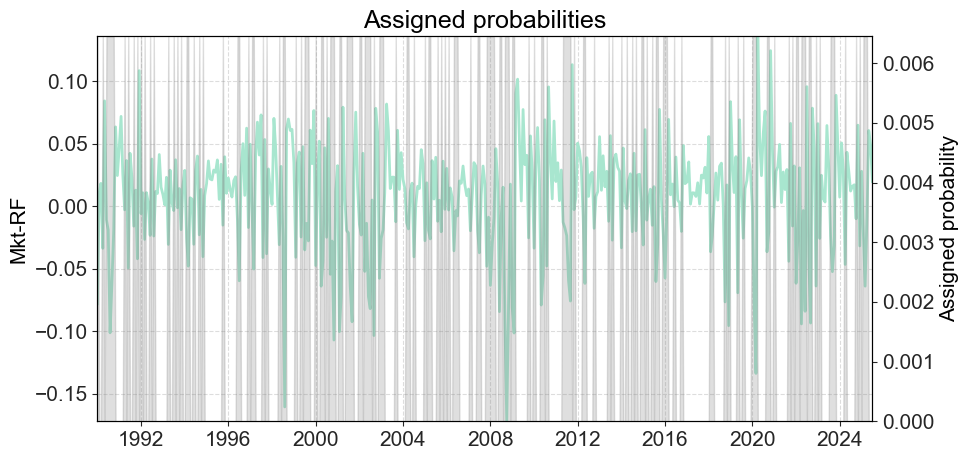

In [17]:
"""
Only assign probabilities to negative market excess return
"""

probs_neg = hp.crisp_conditioning_probs(factors[:, 0], (-np.inf, 0))

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(ff_monthly_returns.index.to_timestamp(), ff_monthly_returns.loc[:, 'Mkt-RF']); 
ax.set_ylabel('Mkt-RF');

ax_new = ax.twinx()

ax_new.fill_between(ff_monthly_returns.index.to_timestamp(), probs_neg, color="gray", alpha=0.25)
ax_new.set_ylabel("Assigned probability")
ax_new.grid(None);

ax.set_title("Assigned probabilities");

In [18]:
# estimate betas
est_xx = calculate_outer_product(factors, factors, probs_neg)
est_xy = calculate_outer_product(factors, excess_returns, probs_neg)

beta_fl = np.linalg.inv(est_xx) @ est_xy
beta_fl

array([[0.96448501],
       [0.3622794 ],
       [0.20516797]])

In [19]:
"""
Factor exposure - risk attribution
"""

'\nFactor exposure - risk attribution\n'

In [20]:
# calculate residual
residual = excess_returns[:, None] -  factors @ beta_fl

# exted factors with residual
extended_factors = np.hstack([factors, residual])

# calculate covariance matrix of factors - with probabilites!
cov_ext_factors = calculate_cov_mat(extended_factors, probs=probs_neg)

# calculate extended beta vector - the exposure to the residual is 1! 
beta_fl_ext = np.vstack([beta_fl, 1.0])

In [21]:
# calculate risk contributions
risk_contrib = calculate_risk_contributions_std(beta_fl_ext.flatten(), cov_ext_factors)

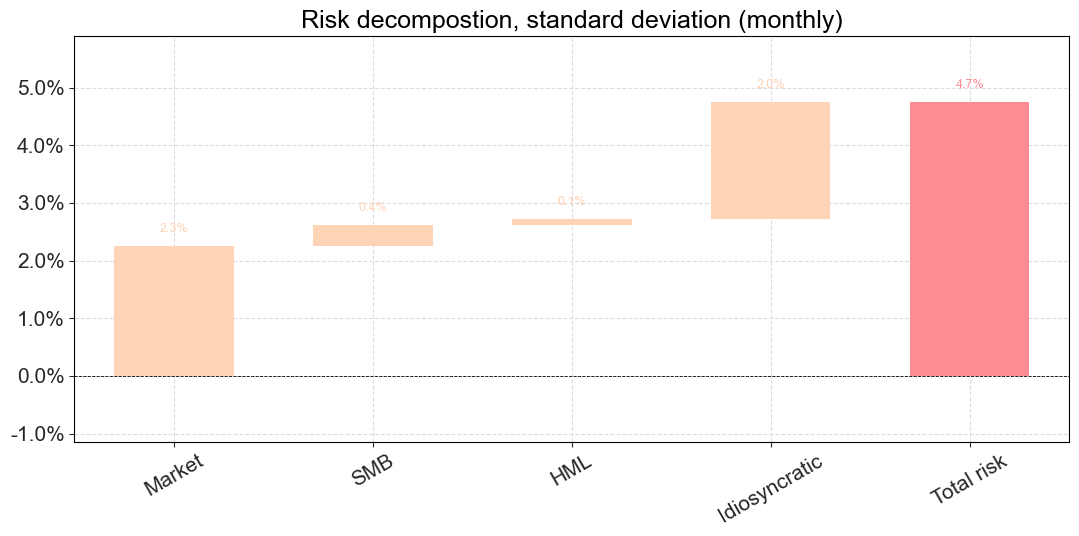

In [22]:
waterfall_chart(values=risk_contrib * 100,
                labels=["Market", "SMB", 'HML', 'Idiosyncratic'],
                formatting='{:,.1f}%',
                total_label="Total risk",
                title="Risk decompostion, standard deviation (monthly)");

fig = plt.gcf()
fig.set_size_inches(12, 6);

## Maximum likelihood estimation (MLE)

[Maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation) is one of the most widely used estimation methods with a number of diserable properties, e.g. it will be the most efficient estimator among consistent asymptotically normal estimators. 

The MLE of $\theta_0$ basically seeks to select the $\theta$ that maximizes the likelihood of observing the actual sample. The joint density of the random sample $f(\mathbf{y}, \mathbf{X}; \theta)$, which will define as the likelihood function, can under an independence assumption be written as the product of the marginal densities 

$$
L_n (\theta \vert \mathbf{y}, \mathbf{X}) = f(\mathbf{y}, \mathbf{X}; \theta) = \prod_{i=1}^n f_{y, \mathbf{x}_i} (y_i, \mathbf{x}_i; \theta)
$$

Since $\ln$ is a positive monotone transformation, we can equivalently maximize the log-likelihood function 

$$
\mathcal{L}_n (\theta \vert \mathbf{y}, \mathbf{X}) = \ln L_n (\theta \vert \mathbf{y}, \mathbf{X}) = \sum_{i=1}^n \ln f_{y, \mathbf{x}_i} (y_i, \mathbf{x}_i; \theta)
$$


### Conditional likelihood

We can factorize a density as the product between the conditional and marginal density

$$
L_n (\theta \vert \mathbf{y}, \mathbf{X}) = f(\mathbf{y}, \mathbf{X}; \theta) = f(\mathbf{y} \vert \mathbf{X}; \theta) f(\mathbf{X}; \theta)  
$$

Typically, we will only focus on the conditional density $f(\mathbf{y} \vert \mathbf{X}; \theta)$ since we are interested in $\mathbf{y}$ given $\mathbf{X}$ (we will do this below). It will not be an issue if $\mathbf{y}$ and $\mathbf{X}$ depends on different sets of parameters, which often will be a reasonable assumption (but not always). 

In _time series modelling_, we also often use the notion of a conditional likelihood function since we cannot always apply an independence assumption.  Assume e.g. that $y_t$ depends on $y_{t-1}$ (and no regressors) then we could factorize (using T to indicate time series context)

$$
\begin{align}
L_T (\theta \vert \mathbf{y}) &= f_{y_0, \dots, y_T}(y_0, \dots, y_T; \theta) \\
&= f_y(y_0; \theta) f_{y_1, \dots, y_T}(y_1, \dots, y_T; \theta) \\
&= f_y(y_0; \theta) \prod_{t=1}^T f_{y_t \vert y_{t-1}}(y_t \vert y_{t-1}; \theta)
\end{align}
$$

dropping $f_y(y_0; \theta)$ will result in the conditional likelihood function that is conditional on the starting value. 

__Remember:__ Most optimizers seek to minimize a function so we may need to multiply with minus one and then minimize. 

__Example: Bernoulli__

Assume that we observe a realization of the random sample $Y_1, ...., Y_{n}$ where $Y_i\sim \text{Bernoulli}(p), i=1,...,n$  

We can write the likelihood function as 

$$
\begin{equation*}
L(p) = \prod_{i=1}^n f_Y(y_i;p) = \prod_{i=1}^n p^{y_i}(1-p) ^{1-y_i} = p^{\sum_{i=1}^n y_i}(1-p)^{\sum_{i=1}^n (1-y_i)}
\end{equation*}
$$

We want to maximize with respect to $p$, but we first take the natural logarithm 

$$
\begin{equation*}
\ln L(p) = \ln (p) \sum_{i=1}^n y_i + \ln(1-p) \sum_{i=1}^n (1-y_i)
\end{equation*}
$$

The first order condition is (take derivative wrt. $p$)

$$
\begin{equation*}
\frac{1}{p} \sum_{i=1}^n y_i - \frac{1}{1-p} \left[n - \sum_{i=1}^n y_i \right] = 0
\end{equation*}
$$

such that we obtain the maximum-likelihood estimate

$$
p_e = \frac{1}{n}\sum_{i=1}^n y_i
$$

Below, we see a simple implementation in Python

In [23]:
"""
Define log-likelihood function
"""

def log_likelihood_function(p, x):
    
    log_like = np.log(p) * np.sum(x) + np.log(1-p) * np.sum(1-x)
    
    return log_like

"""
Generate data
"""
np.random.seed(5)
bernoulli_data = np.random.binomial(1,0.5,size=20)

"""
Minimize negative of log-likelihood
"""
neg_log_lik = lambda p: -log_likelihood_function(p, bernoulli_data)

res = minimize(neg_log_lik, 0.5, bounds={(0.00001,0.99999)})
res.x[0]

np.float64(0.4499999960279612)

### Information matrix equality
 
The [information matrix](https://en.wikipedia.org/wiki/Fisher_information) can equivalently be written as 

$$
I(\theta) = -\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] = \text{E} \left[ \left. \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta } \frac{\partial \mathcal{L}_n (\theta)}{\partial \theta^\top } \right \vert_{\theta = \theta_0}\right]
$$

### Asymptotic distribution 

The asymptotic distribution of the MLE is given by 

$$
\hat{\theta}_{MLE} \sim ^a N\left(\theta_0, -\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}\right)
$$

Note that 

$$
V(\hat{\theta}_{MLE} ) = -\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}
$$

corresponds to Cramér-Rao's lower bound such that the MLE is the most efficient estimator among consistent and asympotically normal estimators. 

__Note:__ To avoid confusion we may note that 

$$
-\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1} = -\left(\text{E} \left[ \left. \sum_{i=1}^n \frac{\partial^2 \ln f_y(y_i; \theta) }{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1} = - \left(n\text{E} \left[ \left.  \frac{\partial^2 \ln f_y(y_i; \theta) }{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}  
$$

__Example: Bernoulli (cont'd)__

For a Bernoulli distribution, we have that 

\begin{equation*}
\ln f_y(y_i;p) = \ln(p) y_i + \ln(1-p) (1-y_i)
\end{equation*}

such that 

$$
\frac{\partial \ln f_y(y_i;p)}{\partial p} = \frac{1}{p}y_i - \frac{1}{1 - p} (1 - y_i)
$$

and 

$$
\frac{\partial \ln f_y(y_i;p)^2}{\partial p^2} = -\frac{1}{p^2}y_i - \frac{1}{(1 - p)^2} (1 - y_i)
$$

Since $\text{E}[y_i] = p$, we obtain

$$
\text{E}\left[\frac{\partial \ln f_y(y_i;p)^2}{\partial p^2} \right] = -\frac{1}{p^2}p - \frac{1}{(1 - p)^2} (1 - p) = -\frac{1}{p} - \frac{1}{1-p} = -\frac{1}{(1-p)p}
$$

Thus, the asymptotic variance is given by 

$$
V(\hat{p}) =  - \left(- n\frac{1}{(1-p)p}\right)^{-1} = \frac{(1-p)p}{n} 
$$

So, when $n$ is large then we have that the distribution of $\hat{p}$ is given by

$$
\hat{p} \sim^a N\left(p, \frac{(1-p)p}{n}  \right)
$$

Let us check it out!

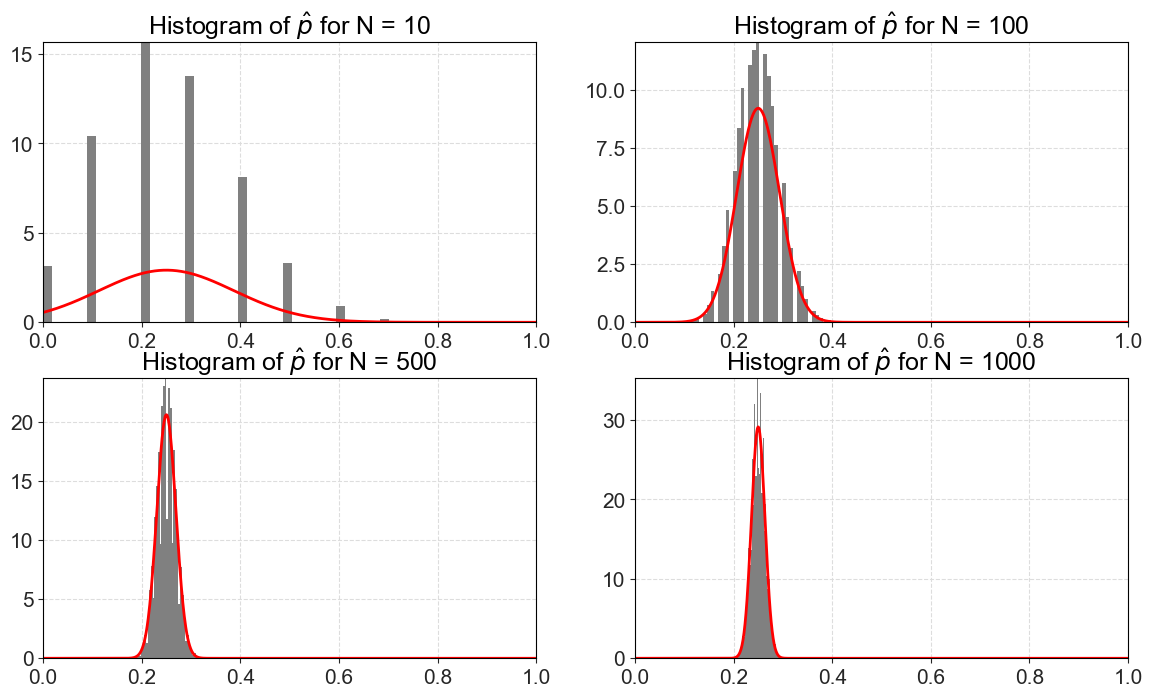

In [24]:
p = 0.25
num_sim = 100000
bernoulli_data = np.random.binomial(1,p,size=(1000, num_sim))

p_vals = np.linspace(0, 1, 1000)

fig, ax_ = plt.subplots(2,2, figsize=(14,8))
ax_ = ax_.flatten()

for i, N in enumerate([10, 100, 500, 1000]): 

    ax = ax_[i]
    
    # asymptotic variance
    asymp_est_var = p*(1 - p) / N
    
    
    # get section of generated data
    data = bernoulli_data[:N, :]
    
    # calculate sample means
    sample_means = np.mean(data, axis=0)
    
    # plot histogram 
    ax.hist(sample_means, color="gray", bins=50, zorder=1, density=True)
    ax.plot(p_vals, stats.norm.pdf(p_vals, loc=p, scale=np.sqrt(asymp_est_var)), color="red")
    
    ax.set_title("Histogram of $\\hat{p}$ for N = " + str(N))
    ax.set_axisbelow(True)
    ax.set_xlim([0,1]);

## Non-linear Least Squares (NLS)

A non-linear regression model specifies the conditional mean as 

$$
\text{E}[y_i \vert \mathbf{x}_i] = g(\mathbf{x}_i; \theta)
$$

or equivalently written as (assuming that $\text{E}[\mathbf{e} \vert \mathbf{x}] = 0$)

$$
y_i = g(\mathbf{x}_i; \theta) + e_i
$$

Clearly, linear regression is the special case $g(\mathbf{x}_i; \beta) = \mathbf{x}_i^\top \beta$. 

The NLS estimator will minimize the sum of squared residuals or minimize (we can scale with $1/2$ without loss of generality)

$$
Q_n(\theta) = - \frac{1}{2n} \sum_{i=1}^n (y_i - g(\mathbf{x}_i; \theta))^2
$$

The FOC gives us 

$$
\frac{\partial Q_n(\theta)}{\partial \theta} = \frac{1}{n} \sum_{i=1}^n \frac{\partial g(\mathbf{x}_i; \theta)}{\partial \theta} (y_i - g(\mathbf{x}_i; \theta)) = \mathbf{0}
$$

or more compactly using matrix notation 

$$
\frac{\partial Q_n(\theta)}{\partial \theta} = \frac{1}{n}\frac{\partial \mathbf{g}^\top}{\partial \theta} (\mathbf{y}- \mathbf{g})
$$

For consistency of the NLS estimator, it is crucial that the mean is specified correctly. 

Assuming a covariance matrix for the errors $\text{E}[\mathbf{e} \mathbf{e}^\top \vert \mathbf{X}] = \boldsymbol{\Omega}_0$
and under regularity conditions, it will be the case that 

$$
\sqrt{n} (\hat{\theta}_{NLS} - \theta_0) \to^d N(0, \mathbf{A}_0^{-1} \mathbf{B}_0 \mathbf{A}_0^{-1})
$$

with 

$$
\begin{align}
\mathbf{A}_0 &= \text{plim} \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \frac{\partial \mathbf{g}}{\partial \theta^\top}  \right \vert_{\theta = \theta_0}\\
\mathbf{B}_0 &= \text{plim} \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \boldsymbol{\Omega}_0 \frac{\partial \mathbf{g}}{\partial \theta^\top} \right \vert_{\theta = \theta_0}
\end{align}
$$

A reasonable estimator for $\mathbf{A}_0$ is 

$$
\hat{\mathbf{A}} = \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \frac{\partial \mathbf{g}}{\partial \theta^\top}\right \vert_{\theta = \hat{\theta}_{NLS}}
$$

For $\mathbf{B}_0$ it depends (just as in the OLS case) on the assumption we can make about $\boldsymbol{\Omega}_0$. Assuming independence implies that $\boldsymbol{\Omega}_0$ must be a diagonal matrix. If homoskedasticity of the error term can be assumed then 

$$
\sqrt{n} (\hat{\theta}_{NLS} - \theta_0) \to^d N(0, \sigma^2 \mathbf{A}_0^{-1})
$$

and we just need to estimate $\sigma^2$ using the sample variance. If we allow for heteroskedasticity, we can estimate 

$$
\hat{\mathbf{B}} = \left. \frac{1}{n} \frac{\partial \mathbf{g}^\top}{\partial \theta} \hat{\boldsymbol{\Omega}}\frac{\partial \mathbf{g}}{\partial \theta^\top}\right \vert_{\theta = \hat{\theta}_{NLS}}
$$

where $\hat{\boldsymbol{\Omega}} = \text{Diag}[\hat{e}_i^2]$. 




## Application: Exponential distribution 

The [exponential density](https://en.wikipedia.org/wiki/Exponential_distribution) is given by

$$
f_Y(y) = \lambda e^{-\lambda y}, \; y > 0, \; \lambda > 0
$$

The mean and variance is respectively $1/\lambda$ and $1/\lambda^2$. The exponential distribution can be used to describe the time for a continuous process to change state or for an event to occur, e.g. time between roadkills on a given road. 

Below we plot the density of a exponential density (with the above parameterization) assuming $\lambda = 12$. On average, we will wait $1/12$ time periods for one event to occur (one month if $y$ is measured in years). 

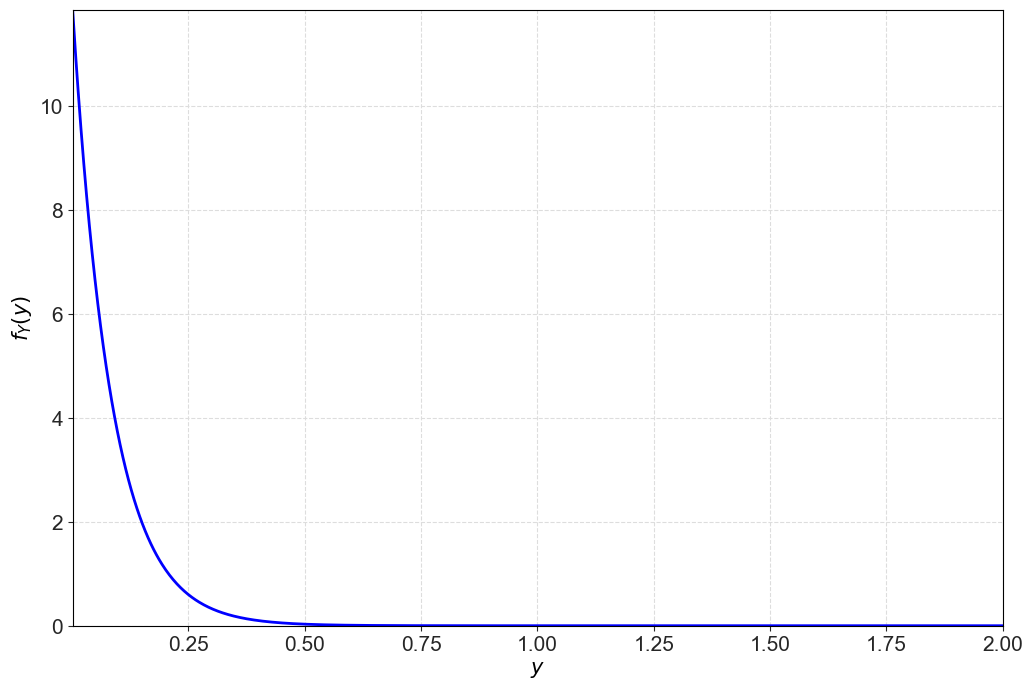

In [25]:
lam = 12.0
y_values = np.linspace(0.001, 2.0, 1000)
pdf_values = stats.expon.pdf(y_values, scale = 1 / lam)

"""
Plotting
"""

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(y_values, pdf_values, color="blue")
ax.set_xlabel('$y$');
ax.set_ylabel('$f_Y(y)$');

We may introduce explanatory variables by specifying 

$$
\lambda = e^{\mathbf{x}^\top \beta} 
$$

ensuring $\lambda > 0$ and specifying the conditional mean as 

$$
\text{E}[y \vert \mathbf{x}] = e^{-\mathbf{x}^\top \beta}
$$

Assume that we observe a realization of a iid random sample $y_i, \mathbf{x}_i$, $i = 1, ... n$. 

### The MLE 

The (conditional) log-likehood function can be written (take the natural logarithm and plug in the definition of $\lambda$)

$$
\mathcal{L}_n (\beta) =  \sum_{i=1}^n  \left[ \mathbf{x}_i^\top \beta - e^{\mathbf{x}_i^\top \beta} y_i\right]
$$


### The NLS estimator

A non-linear least squares estimator can be implemented by estimating 

$$
y_i = e^{-\mathbf{x}_i^\top \beta} + e_i
$$

We also note that the error term is heteroskedastic since $\text{Var}[y_i] = 1 / [e^{\mathbf{x}_i^\top \beta}]^2$. 

### Simulating data and implementing estimators

We consider 10,000 iid draws from the data generating process

$$
y \sim \text{Exp}(\beta_1 + \beta_2 x)
$$

with $x \sim N(1, 1)$ and $(\beta_1, \beta_2) = (2, -1)$.

#### MLE

Below we implement the (negative) log-likelhood function and minimize it.

In [26]:
"""
Simulate data
"""
n_sim = 10000

beta1 = 2
beta2 = -1.0
beta = np.array([beta1, beta2])

x_data = np.random.normal(loc=1, scale=1, size=n_sim)
x_data = np.c_[np.ones(n_sim), x_data]
y_data = np.random.exponential(scale = 1 / np.exp(x_data @ beta), size=n_sim)

In [27]:
"""
Define log-likelihood function (negative)
"""


def log_likelihood_function(beta, y, x, individual=False):
    
    log_like = x @ beta - np.exp(x @ beta) * y
    
    if individual: 
        return -log_like
    else:
        return -np.sum(log_like)

"""
Minimize negative log-likelihood 
"""
res_dict = {}
res_dict['MLE'] = {}

res = minimize(log_likelihood_function, [0.5, 0.5], args=(y_data, x_data))
params_mle = res.x
params_mle

array([ 1.97406571, -0.998121  ])

It is possible to show that (in this particular case)

$$
\text{Var}[\hat{\beta}] = - \left[-n \text{E}\left[\mathbf{x}_i \mathbf{x}_i^\top \right]\right]^{-1}
$$

For futher details see the notebook __m_estimators [optional]__. 

A common approach is to use numerical derivatives or other tools to estimate the asymptotic variance

$$
\widehat{V}(\hat{\theta}_{MLE} ) = -\left(\text{E} \left[ \left. \frac{\partial^2 \mathcal{L}_n (\theta)}{\partial \theta \partial \theta^\top} \right \vert_{\theta = \theta_0}\right] \right)^{-1}
$$

Below we use the `statsmodels.tools.numdiff` package.  

In [28]:
scores = approx_fprime(params_mle, log_likelihood_function, args=(y_data, x_data, True))
B_approx = scores.T @ scores 

A_approx = -approx_hess(params_mle, log_likelihood_function, args=(y_data, x_data))

# using the Hessian 
param_mle_cov_A_num = np.linalg.inv(-A_approx)

# using the outer product of the scores
param_mle_cov_B_num = np.linalg.inv(B_approx)

# Using the sandwich estimator - more robust to misspecification of distribution
param_mle_cov_sandwich_num = np.linalg.inv(A_approx) @ B_approx @ np.linalg.inv(A_approx)

In [29]:
# covariance matrix based on A
param_mle_cov_A_num

array([[ 0.00020101, -0.00010161],
       [-0.00010161,  0.00010221]])

In [30]:
# covariance matrix based on B
param_mle_cov_B_num

array([[ 0.00020883, -0.00010828],
       [-0.00010828,  0.00010739]])

In [31]:
# covariance matrix based on A^{-1}BA^{-1} "Sandwich formula"
param_mle_cov_sandwich_num

array([[ 1.93622026e-04, -9.52794384e-05],
       [-9.52794384e-05,  9.73027335e-05]])

We have specified the model correctly and have lots of data, so it is no surprice that maximum likelihood performs well. Due to the information matrix equality, then using different variance estimators gives us very similar results. 

#### NLS

Next, we define the NLS objective and minimze it. 

In [32]:
def objective_nls(beta, y, x, individual=False): 
    
    loss = np.square(y - np.exp(-x @ beta)) 
    
    if individual: 
        return loss
    else:
        return np.sum(loss) / len(y)
    
def foc_nls(beta, y, x): 
    
    der = (y - np.exp(-x @ beta)) * np.exp(-x @ beta) @ x

    return np.sum(der)


In [33]:
res_dict['NLS'] = {}

res = minimize(objective_nls, [1.0, -2.0], args=(y_data, x_data, False))
params_nls = res.x
params_nls

array([ 1.99151912, -0.99323457])

In [34]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.8193158607208716
        x: [ 1.992e+00 -9.932e-01]
      nit: 25
      jac: [-1.490e-07 -5.960e-07]
 hess_inv: [[ 6.573e+00 -2.091e+00]
            [-2.091e+00  7.248e-01]]
     nfev: 81
     njev: 27

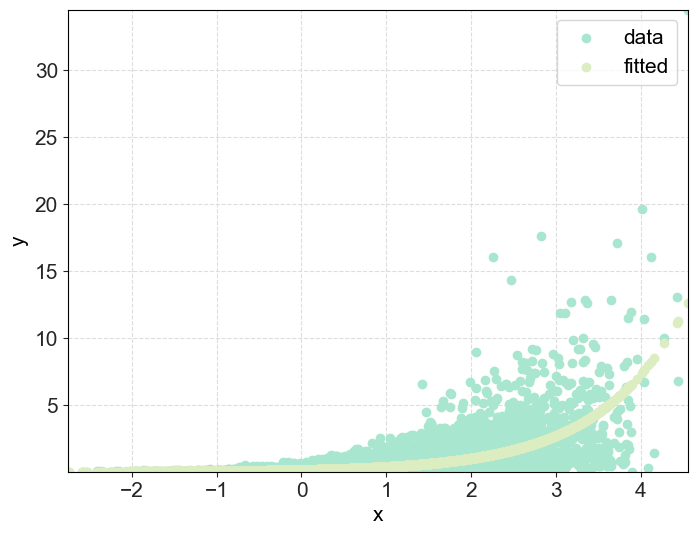

In [35]:
"""
Clearly the error term is heteroskedastic...
"""
fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x_data[:, 1], y_data, label="data")
ax.scatter(x_data[:, 1],  np.exp(-x_data @ params_nls), label="fitted")

ax.set_xlabel('x', size=15)
ax.set_ylabel('y', size=15)

ax.legend();

Next step is to calculate the variance of the NLS estimator. Again, we can either use the exact analytical expressions or use numerical derivatives. We consider the analytical derivatives. 

We implement 

$$
\begin{align}
\frac{1}{n} \sum_{i=1}^n \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &= \frac{1}{n} \sum_{i=1}^n e^{2\mathbf{x}_i^\top \beta}\mathbf{x}_i \mathbf{x}_i^\top \\
\frac{1}{n} \sum_{i=1}^n \sigma_i^2 \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta } \frac{\partial g_i(y_i, \mathbf{x}_i ;\beta)}{\partial \beta^\top }  &=  \frac{1}{n} \sum_{i=1}^n e^{-2\mathbf{x}_i^\top \beta} e^{2\mathbf{x}_i^\top \beta}\mathbf{x}_i \mathbf{x}_i^\top = \frac{1}{n} \sum_{i=1}^n \mathbf{x}_i \mathbf{x}_i^\top
\end{align}
$$

In [36]:
def calculate_scores_g(beta: np.ndarray, y: np.ndarray, x: np.ndarray) -> np.ndarray:
    
    """
    Calculates the score
    """
    
    return np.exp(-x @ beta)[:, None] * x

In [37]:
scores_g = calculate_scores_g(params_nls, y_data, x_data)

In [38]:
A = scores_g.T @ scores_g
B = scores_g.T @ np.diag(np.exp(-2*x_data @ params_nls)) @ scores_g
B_alt = scores_g.T @ np.diag((y_data - np.exp(-x_data @ params_nls) )**2) @ scores_g

In [39]:
param_nls_cov_A = np.linalg.inv(A) #<-- understates variance

param_nls_cov_B = np.linalg.inv(B) #<-- understates variance

param_nls_cov_sandwich = np.linalg.inv(A) @ B @ np.linalg.inv(A) #<-- valid estimator due to heteroskedasticity

In [40]:
param_nls_cov_B

array([[ 2.97365071e-04, -7.42795751e-05],
       [-7.42795751e-05,  1.89196743e-05]])

In [41]:
param_nls_cov_sandwich

array([[ 0.02368708, -0.01021187],
       [-0.01021187,  0.00448676]])

## Estimation using SciPy

`scipy` provides MLE methods for implemented distributions (see e.g. [here](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.rv_continuous.fit.html)). For instance, we can fit the parameters of a normal distribution. 

In [42]:
"""
Simulate Normal data and estimate parameters
"""

num_sim = 10000
sigma = 1
mu = 5


norm_data = np.random.normal(loc=mu, scale=sigma, size=num_sim)

# Known MLE 
mu_est = np.mean(norm_data)
variance_est = np.var(norm_data)
sigma_est = np.sqrt(variance_est)

print("MLE mu: " + str(mu_est))
print("MLE std: " + str(sigma_est) + "\n")

# fit using SciPy
mu_scipy_est, sigma_scipy_est = stats.norm.fit(norm_data)

print("SciPy mu: " + str(mu_scipy_est))
print("SciPy std: " + str(sigma_scipy_est))

MLE mu: 5.0137913124204605
MLE std: 1.0142671692558516

SciPy mu: 5.0137913124204605
SciPy std: 1.0142671692558516


## Estimation using Statsmodels

`scipy` provides a quick MLE implementation for different distributions, but may not be applicable for more complicated problem. 

`statsmodels` provides a framework for implementing generic MLE estimators (see [docs](https://www.statsmodels.org/dev/examples/notebooks/generated/generic_mle.html)). Let us try to implement our exponential model using `statsmodels`!

In [43]:
from statsmodels.base.model import GenericLikelihoodModel

# overwrite loglikelihood function in Generic Likelihood Class
class Exponential(GenericLikelihoodModel):
    
    def loglike(self, params):
        exog = self.exog
        endog = self.endog
        return (exog @ params - np.exp(exog @ params) * endog).sum()

# fit models
exponential_fit = Exponential(y_data, x_data).fit()

# print results
print(exponential_fit.summary())

Optimization terminated successfully.
         Current function value: 0.018170
         Iterations: 52
         Function evaluations: 99
                             Exponential Results                              
Dep. Variable:                      y   Log-Likelihood:                -181.70
Model:                    Exponential   AIC:                             367.4
Method:            Maximum Likelihood   BIC:                             381.8
Date:                Sun, 05 Oct 2025                                         
Time:                        22:40:06                                         
No. Observations:               10000                                         
Df Residuals:                    9998                                         
Df Model:                           1                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------

In [44]:
"""
Our previous estimates
"""

params_mle

array([ 1.97406571, -0.998121  ])

# References

## Books

 [Microeconometrics: Methods and Applications, Cameron and Trivedi (2005)](https://www.cambridge.org/highereducation/books/microeconometrics/982158DE989697607C858068ED05C7B1#overview)
 
 [Econometric Analysis 7th edition, William H. Greene (2012)](https://www.amazon.com/Econometric-Analysis-7th-William-Greene/dp/0131395386)
